In [12]:

import torch
import torch.utils.benchmark as benchmark
from torch import nn
from torch import optim

import matplotlib.pyplot as plt
from models import ResNetDyT, ResNetLN
from dataset import get_dataloader
from utils import set_seed, init_model_weights, compare_weights

import mpld3

In [13]:
SEED=42
set_seed(SEED)

In [14]:
# Instantiate the models
model_ln = ResNetLN()
model_dyt = ResNetDyT()
init_model_weights([model_ln, model_dyt])

In [15]:
# check if they have the same weights
if compare_weights(model_ln, model_dyt):
    print("Good: The models have the same weights")
else:
    print("Problem: The models have different weights")

Good: The models have the same weights


In [20]:
def train_model(model, optim, batch_size=128, seed=42):
    # getting the seeded data
    train_loader, test_loader = get_dataloader(batch_size=batch_size, seed=seed)

    for batch in train_loader:
        x, y = batch
        optim.zero_grad()
        y_hat , _ = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optim.step()


In [9]:
def inference_model(model, batch_size=128, seed=42):
    # getting the seeded data
    model = model.eval()
    _, test_loader = get_dataloader(batch_size=batch_size, seed=seed)

    total_loss = 0

    for batch in test_loader:
        x, y = batch
        y_hat , _ = model(x)
        loss = criterion(y_hat, y)

        total_loss += loss.item()
    return total_loss/len(test_loader)

In [10]:
# Sample input data: a single 3-channel 32x32 image
input_data = torch.randn(128, 3, 32, 32)
# Forward pass to collect data
output_ln_init, ln_data_init = model_ln(input_data)
output_dyt_init, dyt_data_init = model_dyt(input_data)

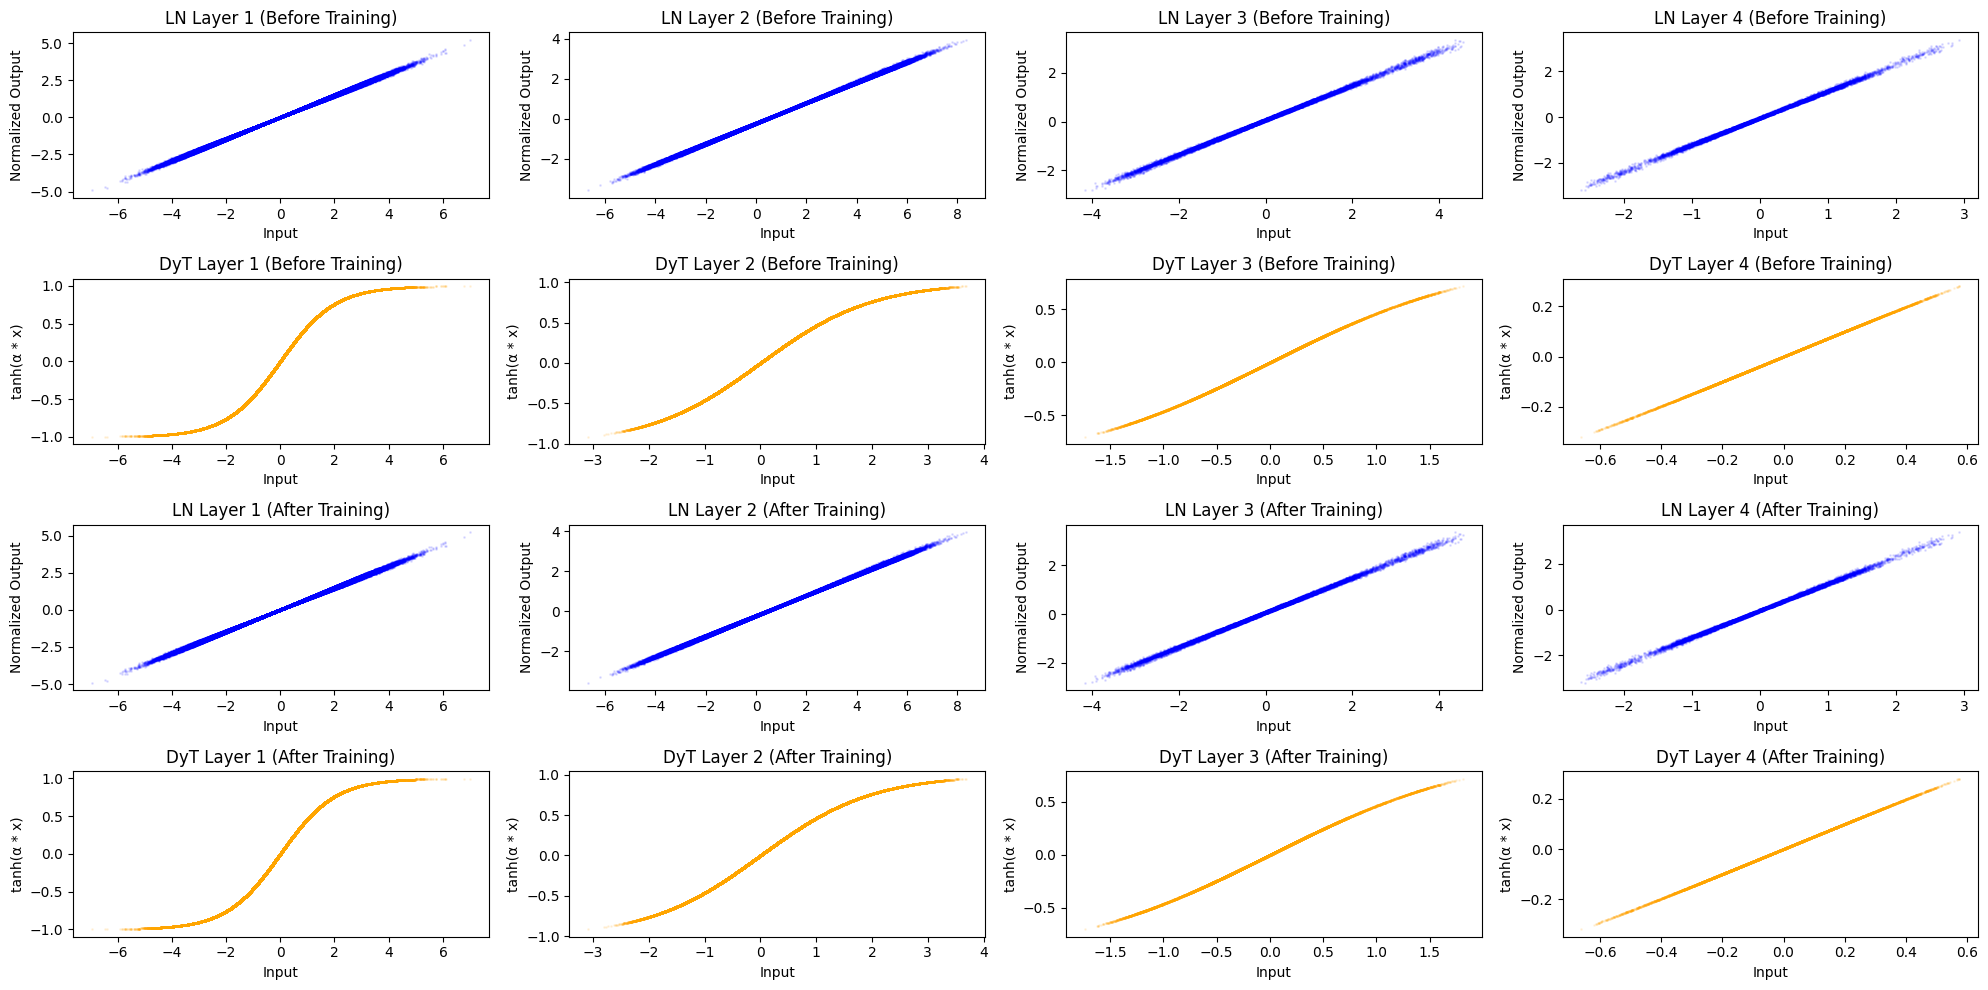

In [11]:
input_data = torch.randn(128, 3, 32, 32)
# Forward pass to collect data
output_ln_init, ln_data_init = model_ln(input_data)
output_dyt_init, dyt_data_init = model_dyt(input_data)
# Create a 4x4 subplot grid
fig, axes = plt.subplots(4, 4, figsize=(20, 10))

# Plot the data before and after training

for i in range(4):
    # LN layer visualization
    x_ln, normalized_ln = ln_data_init[i]
    x_ln_flat = x_ln.flatten().detach().cpu().numpy()
    normalized_ln_flat = normalized_ln.flatten().detach().cpu().numpy()
    axes[0, i].scatter(x_ln_flat, normalized_ln_flat, alpha=0.1, s=1, color='blue')
    axes[0, i].set_title(f'LN Layer {i+1} (Before Training)')
    axes[0, i].set_xlabel('Input')
    axes[0, i].set_ylabel('Normalized Output')

    # DyT layer visualization
    x_dyt, tanh_dyt = dyt_data_init[i]
    x_dyt_flat = x_dyt.flatten().detach().cpu().numpy()
    tanh_dyt_flat = tanh_dyt.flatten().detach().cpu().numpy()
    axes[1, i].scatter(x_dyt_flat, tanh_dyt_flat, alpha=0.1, s=1, color='orange')
    axes[1, i].set_title(f'DyT Layer {i+1} (Before Training)')
    axes[1, i].set_xlabel('Input')
    axes[1, i].set_ylabel('tanh(α * x)')

    # LN layer visualization
    x_ln, normalized_ln = ln_data_init[i]
    x_ln_flat = x_ln.flatten().detach().cpu().numpy()
    normalized_ln_flat = normalized_ln.flatten().detach().cpu().numpy()
    axes[2, i].scatter(x_ln_flat, normalized_ln_flat, alpha=0.1, s=1, color='blue')


    axes[2, i].set_title(f'LN Layer {i+1} (After Training)')
    axes[2, i].set_xlabel('Input')
    axes[2, i].set_ylabel('Normalized Output')

    # DyT layer visualization
    x_dyt, tanh_dyt = dyt_data_init[i]
    x_dyt_flat = x_dyt.flatten().detach().cpu().numpy()
    tanh_dyt_flat = tanh_dyt.flatten().detach().cpu().numpy()
    axes[3, i].scatter(x_dyt_flat, tanh_dyt_flat, alpha=0.1, s=1, color='orange')
    axes[3, i].set_title(f'DyT Layer {i+1} (After Training)')
    axes[3, i].set_xlabel('Input')
    axes[3, i].set_ylabel('tanh(α * x)')

# Adjust layout and display
plt.tight_layout()

# save as pdf
# width = 600
fig.savefig("/Users/mac/Documents/git/ju2ez.github.io/assets/img/deep_learning/tanh/models_shape_init.png",
            dpi=300, format="png", bbox_inches="tight")

plt.show()

In [8]:
# Sample input data
input_data = torch.randn(128, 3, 32, 32)

# Forward pass to collect data (replace with your actual models)
# Assuming model_ln and model_dyt return output and a list of (input, output) tuples for 4 layers
output_ln_init, ln_data_init = model_ln(input_data)  # Before training
output_dyt_init, dyt_data_init = model_dyt(input_data)  # Before training
output_ln_trained, ln_data_trained = model_ln(input_data)  # After training (example)
output_dyt_trained, dyt_data_trained = model_dyt(input_data)  # After training (example)

# Create a 4x4 subplot grid
fig = make_subplots(
    rows=4,
    cols=4,
    subplot_titles=(
        [f'LN Layer {i+1} (Before Training)' for i in range(4)] +
        [f'DyT Layer {i+1} (Before Training)' for i in range(4)] +
        [f'LN Layer {i+1} (After Training)' for i in range(4)] +
        [f'DyT Layer {i+1} (After Training)' for i in range(4)]
    ),
    vertical_spacing=0.1,
    horizontal_spacing=0.05
)

# Plot data for each layer
for i in range(4):
    # LN Layer (Before Training) - Row 1
    x_ln, normalized_ln = ln_data_init[i]
    x_ln_flat = x_ln.flatten().detach().cpu().numpy()
    normalized_ln_flat = normalized_ln.flatten().detach().cpu().numpy()
    fig.add_trace(
        go.Scattergl(
            x=x_ln_flat,
            y=normalized_ln_flat,
            mode='markers',
            marker=dict(size=1, opacity=0.1, color='blue'),
            name=f'LN Layer {i+1} Before'
        ),
        row=1,
        col=i+1
    )

    # DyT Layer (Before Training) - Row 2
    x_dyt, tanh_dyt = dyt_data_init[i]
    x_dyt_flat = x_dyt.flatten().detach().cpu().numpy()
    tanh_dyt_flat = tanh_dyt.flatten().detach().cpu().numpy()
    fig.add_trace(
        go.Scattergl(
            x=x_dyt_flat,
            y=tanh_dyt_flat,
            mode='markers',
            marker=dict(size=1, opacity=0.1, color='orange'),
            name=f'DyT Layer {i+1} Before'
        ),
        row=2,
        col=i+1
    )

    # LN Layer (After Training) - Row 3
    x_ln, normalized_ln = ln_data_trained[i]
    x_ln_flat = x_ln.flatten().detach().cpu().numpy()
    normalized_ln_flat = normalized_ln.flatten().detach().cpu().numpy()
    fig.add_trace(
        go.Scattergl(
            x=x_ln_flat,
            y=normalized_ln_flat,
            mode='markers',
            marker=dict(size=1, opacity=0.1, color='blue'),
            name=f'LN Layer {i+1} After'
        ),
        row=3,
        col=i+1
    )

    # DyT Layer (After Training) - Row 4
    x_dyt, tanh_dyt = dyt_data_trained[i]
    x_dyt_flat = x_dyt.flatten().detach().cpu().numpy()
    tanh_dyt_flat = tanh_dyt.flatten().detach().cpu().numpy()
    fig.add_trace(
        go.Scattergl(
            x=x_dyt_flat,
            y=tanh_dyt_flat,
            mode='markers',
            marker=dict(size=1, opacity=0.1, color='orange'),
            name=f'DyT Layer {i+1} After'
        ),
        row=4,
        col=i+1
    )

# Update axes labels (optional, can be customized per subplot if needed)
fig.update_xaxes(title_text="Input")
fig.update_yaxes(title_text="Output")  # Note: This applies globally; adjust per subplot if needed

# Update layout
fig.update_layout(
    height=1000,
    width=1000,
    title_text="LN and DyT Layers Before and After Training",
    showlegend=False  # Set to True if you want a legend
)

# Show the plot
fig.show()  # Inline in VS Code

# Optional: Save to HTML to view in a browser (recommended if VS Code still struggles)
fig.write_html("scatter_plot.html")

NameError: name 'make_subplots' is not defined

In [17]:
optimizer_ln = optim.Adam(model_ln.parameters(), lr=0.001)
optimizer_dyt = optim.Adam(model_dyt.parameters(), lr=0.001)

In [18]:
criterion = nn.CrossEntropyLoss()

In [12]:
benchmark_ln = benchmark.Timer(
    stmt='train_model(model_ln, optimizer_ln)',
    globals=globals()
)

benchmark_dyt = benchmark.Timer(
    stmt='train_model(model_dyt, optimizer_dyt)',
    globals=globals()
)

In [13]:
# Collect at least 10 independent timing measurements
times_ln = [benchmark_ln.timeit(1).mean for _ in range(100)]  # 100 independent runs
times_dyt = [benchmark_dyt.timeit(1).mean for _ in range(100)]  # 100 independent runs

In [70]:
benchmark_inference_ln = benchmark.Timer(
    stmt='inference_model(model_ln)',
    globals=globals()
)

benchmark_inference_dyt = benchmark.Timer(
    stmt='inference_model(model_dyt)',
    globals=globals()
)



In [72]:
inf_times_ln = [benchmark_inference_ln.timeit(1).mean for _ in range(100)]  # 100 independent runs
inf_times_dyt = [benchmark_inference_dyt.timeit(1).mean for _ in range(100)]  # 100 independent runs


In [74]:
print("average time for training LN model: ", sum(times_ln)/len(times_ln))
print("average time for training DyT model: ", sum(times_dyt)/len(times_dyt))

average time for training LN model:  25.542725474980088
average time for training DyT model:  23.767970249159845


In [76]:
print("average time for inference LN model: ", sum(inf_times_ln)/len(inf_times_ln))
print("average time for inference DyT model: ", sum(inf_times_dyt)/len(inf_times_dyt))

average time for inference LN model:  15.442685342560035
average time for inference DyT model:  14.51143476124991


In [1]:
print("speedup for inference: ", sum(inf_times_ln)/len(inf_times_ln) / (sum(inf_times_dyt)/len(inf_times_dyt)))

NameError: name 'inf_times_ln' is not defined

In [ ]:
# Plot box plot with plotly
import plotly.express as px

fig = px.box(y=[times_ln, times_dyt], labels={'y': 'Time (s)', 'x': 'Model'}, title=' Layernorm vs. DyT on one Epoch CIFAR-10 (100 runs)')

# rename wide_variable and x and y axis
fig.update_xaxes(title_text='Model', tickvals=[0, 1], ticktext=['LN', 'DyT'])
fig.update_yaxes(title_text='Time (s)')

fig.show(config={"displayModeBar": False})

# Info:
# one epoch of training with CIFA-10 dataset and batch size of 128
# 10 independent runs


fig.write_html("/Users/mac/Documents/git/ju2ez.github.io/assets/img/deep_learning/tanh/training_time_comparison.html")

In [3]:
import plotly.express as px
# Plot box plot with plotly
# four box plots, two for training and two for inference

fig = px.box(y=[times_ln, times_dyt, inf_times_ln, inf_times_dyt],
                labels={'y': 'Time (s)', 'x': 'Model', 'color': 'Type'},
                title=' Layernorm vs. DyT on one Epoch CIFAR-10 (100 runs) - Training and Inference')
# rename wide_variable and x and y axis
fig.update_xaxes(title_text='', tickvals=[0, 1, 2, 3], ticktext=['LN (train)', 'DyT (train)', 'LN (inference)', 'DyT (inference)'])
fig.update_yaxes(title_text='Time (s)')
fig.show(config={"displayModeBar": False})

fig.write_html("/Users/mac/Documents/git/ju2ez.github.io/assets/img/deep_learning/tanh/training_inference_time_comparison.html")

NameError: name 'times_ln' is not defined

In [ ]:
# increase in performance: dyt vs ln
relative_time = sum(times_dyt)/sum(times_ln)  # in percent
#print(f"Training with DyT is {relative_time:.2f}x faster than training with LN")
print("Training with DyT is roughly {:.3}% faster than training with LN".format((1-relative_time)*100))

Training with DyT is roughly 6.95% faster than training with LN


In [66]:
print("Training with DyT is roughly {:.3}% faster than training with LN".format((1-relative_time)*100))

Training with DyT is roughly 6.95% faster than training with LN


In [37]:
print("Average training time for LN: {:.2f} s".format(sum(times_ln)/len(times_ln)))
print("Average training time for DyT: {:.2f} s".format(sum(times_dyt)/len(times_dyt)))

Average training time for LN: 25.54 s
Average training time for DyT: 23.77 s


In [29]:
model_ln_init = ResNetLN()
model_dyt_init = ResNetDyT()
init_model_weights([model_ln_init, model_dyt_init])

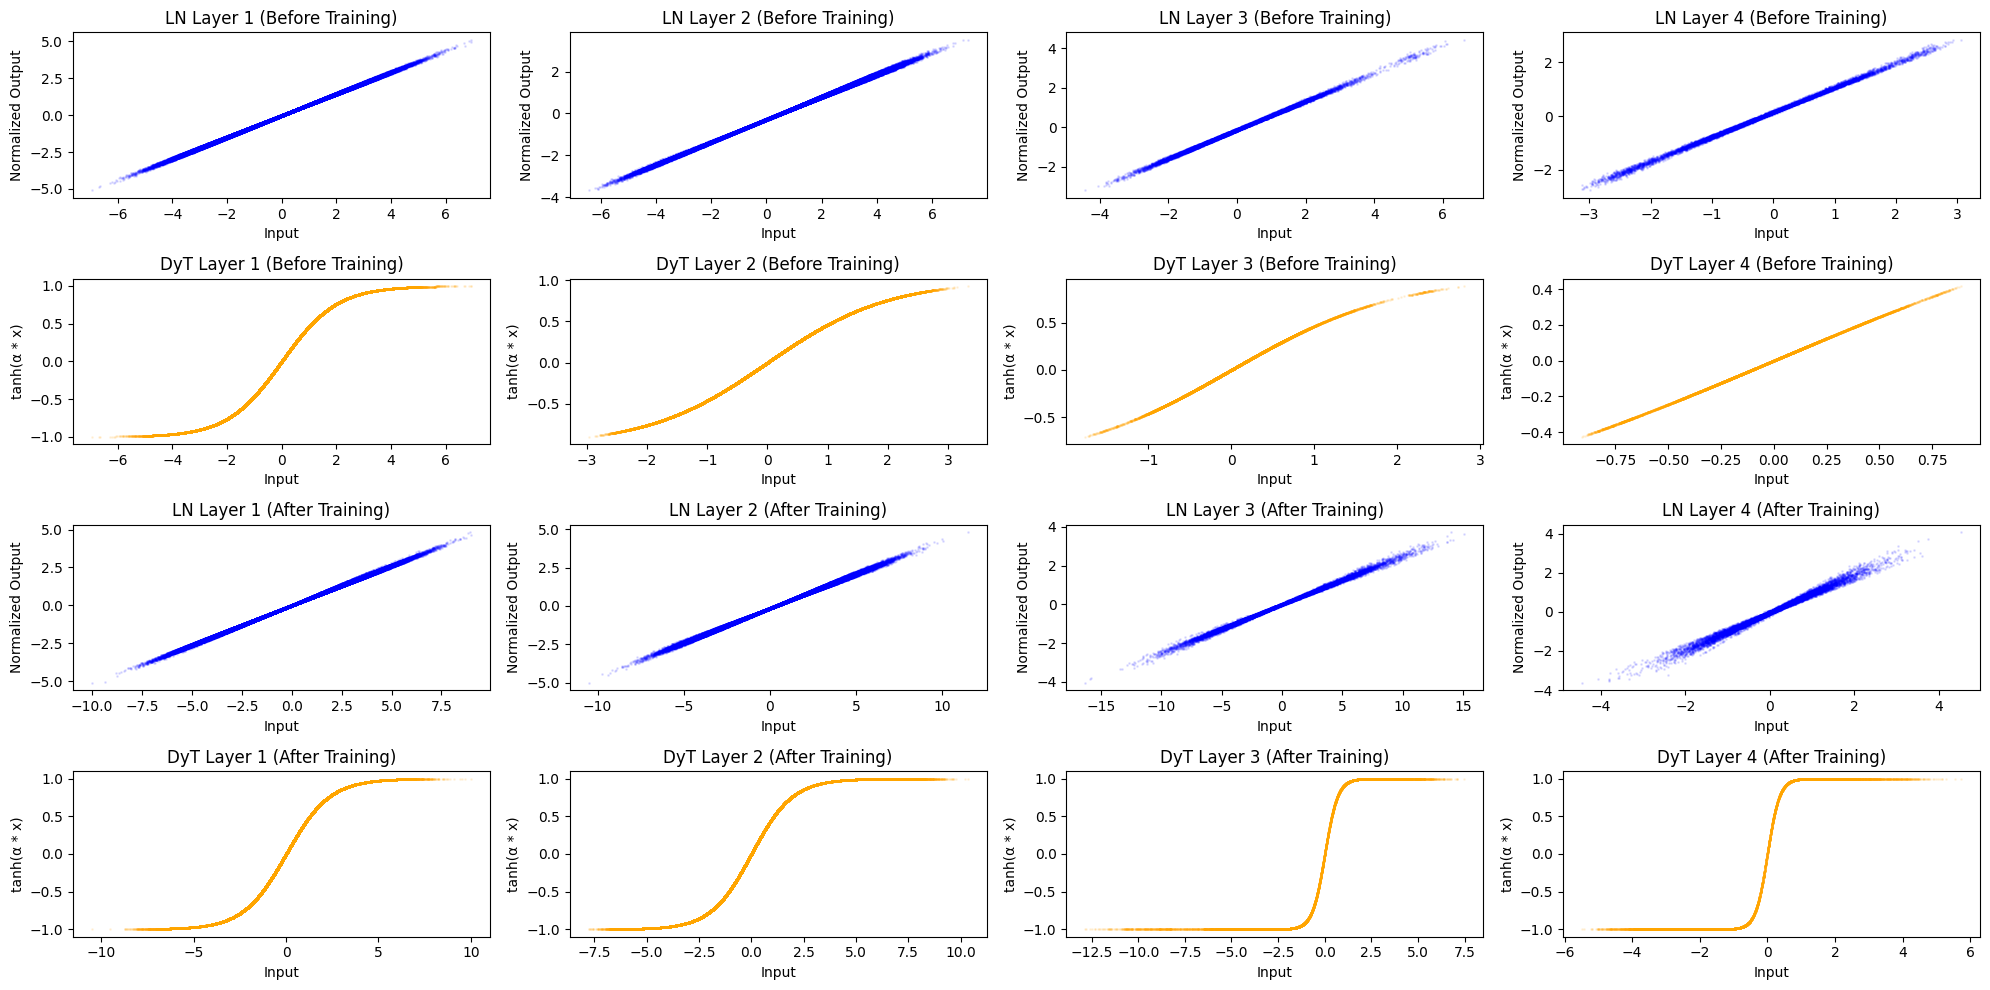

In [30]:
input_data = torch.randn(128, 3, 32, 32)
# Forward pass to collect data
output_ln_init, ln_data_init = model_ln_init(input_data)
output_dyt_init, dyt_data_init = model_dyt_init(input_data)

output_ln_post, ln_data_post = model_ln(input_data)
output_dyt_post, dyt_data_post = model_dyt(input_data)

# Create a 4x4 subplot grid
fig, axes = plt.subplots(4, 4, figsize=(20, 10))

# Plot the data before and after training

for i in range(4):
    # LN layer visualization
    x_ln, normalized_ln = ln_data_init[i]
    x_ln_flat = x_ln.flatten().detach().cpu().numpy()
    normalized_ln_flat = normalized_ln.flatten().detach().cpu().numpy()
    axes[0, i].scatter(x_ln_flat, normalized_ln_flat, alpha=0.1, s=1, color='blue')
    axes[0, i].set_title(f'LN Layer {i+1} (Before Training)')
    axes[0, i].set_xlabel('Input')
    axes[0, i].set_ylabel('Normalized Output')

    # DyT layer visualization
    x_dyt, tanh_dyt = dyt_data_init[i]
    x_dyt_flat = x_dyt.flatten().detach().cpu().numpy()
    tanh_dyt_flat = tanh_dyt.flatten().detach().cpu().numpy()
    axes[1, i].scatter(x_dyt_flat, tanh_dyt_flat, alpha=0.1, s=1, color='orange')
    axes[1, i].set_title(f'DyT Layer {i+1} (Before Training)')
    axes[1, i].set_xlabel('Input')
    axes[1, i].set_ylabel('tanh(α * x)')

    # LN layer visualization
    x_ln, normalized_ln = ln_data_post[i]
    x_ln_flat = x_ln.flatten().detach().cpu().numpy()
    normalized_ln_flat = normalized_ln.flatten().detach().cpu().numpy()
    axes[2, i].scatter(x_ln_flat, normalized_ln_flat, alpha=0.1, s=1, color='blue')


    axes[2, i].set_title(f'LN Layer {i+1} (After Training)')
    axes[2, i].set_xlabel('Input')
    axes[2, i].set_ylabel('Normalized Output')

    # DyT layer visualization
    x_dyt, tanh_dyt = dyt_data_post[i]
    x_dyt_flat = x_dyt.flatten().detach().cpu().numpy()
    tanh_dyt_flat = tanh_dyt.flatten().detach().cpu().numpy()
    axes[3, i].scatter(x_dyt_flat, tanh_dyt_flat, alpha=0.1, s=1, color='orange')
    axes[3, i].set_title(f'DyT Layer {i+1} (After Training)')
    axes[3, i].set_xlabel('Input')
    axes[3, i].set_ylabel('tanh(α * x)')

# Adjust layout and display
plt.tight_layout()

# save as pdf
# width = 600
fig.savefig("/Users/mac/Documents/git/ju2ez.github.io/assets/img/deep_learning/tanh/models_shape_init_post.png",
            dpi=300, format="png", bbox_inches="tight")

plt.show()

In [16]:
# Use blocked_autorange to get multiple measurements
measurement = benchmark_ln.blocked_autorange()

# Extract the list of timing measurements
times = measurement.times

# Create a boxplot
plt.boxplot(times)
plt.ylabel("Time (seconds)")
plt.title("Execution Time Distribution")
plt.show()

KeyboardInterrupt: 

In [ ]:
results = benchmark_ln.repeat(repeat=10, number=1)  # 10 runs, 1 execution per run

In [ ]:
import plotly.express as px
import pandas as pd

# Convert benchmark times to a DataFrame for easy plotting
df = pd.DataFrame({
    "Run": range(1, 11),  # 10 runs
    "Time (seconds)": times_train
})

# Create the box plot
fig = px.box(df, y="Time (seconds)", title="Benchmark Distribution of Training Times")

# Customize the plot
fig.update_layout(
    xaxis_title="Run Number",
    yaxis_title="Time (seconds)",
    showlegend=False
)

# Show the plot
fig.show()


In [24]:
train_loader, test_loader = get_dataloader(batch_size=128, seed=42)

In [25]:
train_loader

In [26]:
# compare the two models
epoch_train_loss_ln = []
epoch_train_loss_dyt = []
epoch_test_loss_ln = []
epoch_test_loss_dyt = []
epoch_test_acc_ln = []
epoch_test_acc_dyt = []

# we train for 100 epochs
for epoch in range(1, 101):
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer_ln.zero_grad()
        optimizer_dyt.zero_grad()

        # forward + backward + optimize
        outputs_ln, _ = model_ln(inputs)
        loss_ln = criterion(outputs_ln, labels)
        loss_ln.backward()
        optimizer_ln.step()

        outputs_dyt, _ = model_dyt(inputs)
        loss_dyt = criterion(outputs_dyt, labels)
        loss_dyt.backward()
        optimizer_dyt.step()

        # print statistics
        if i % 2000 == 1999:
            print(f'[{epoch}, {i + 1}] loss_ln: {loss_ln.item()}, loss_dyt: {loss_dyt.item()}')

    epoch_train_loss_ln.append(loss_ln.item())
    epoch_train_loss_dyt.append(loss_dyt.item())

    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        outputs_ln, _ = model_ln(inputs)
        loss_ln = criterion(outputs_ln, labels)
        outputs_dyt, _ = model_dyt(inputs)
        loss_dyt = criterion(outputs_dyt, labels)

        if i % 2000 == 1999:
            print(f'[{epoch}, {i + 1}] test_loss_ln: {loss_ln.item()}, test_loss_dyt: {loss_dyt.item()}')

    epoch_test_loss_ln.append(loss_ln.item())
    epoch_test_loss_dyt.append(loss_dyt.item())
    #epoch_test_acc_ln.append(evaluate(model_ln, test_loader))
    #epoch_test_acc_dyt.append(evaluate(model_dyt, test_loader))

In [ ]:
# : random seed (generator) !DONE
# : init model with the same weights !DONE
# : both models should train with the same data !DONE
#TODO: proper benchmark off the time
#TODO: proper benchmark off the accuracy
#TODO : compare the results

In [ ]:
# plot loss curves
plt.figure(figsize=(10, 5))

plt.plot(epoch_train_loss_ln, label='Train Loss LN', color='green')
plt.plot(epoch_train_loss_dyt, label='Train Loss DyT', color='yellow')
plt.plot(epoch_test_loss_ln, label='Test Loss LN', color='purple')
plt.plot(epoch_test_loss_dyt, label='Test Loss DyT', color='pink')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, 100)), y=epoch_train_loss_ln, mode='lines', name='Train Loss LN'))
fig.add_trace(go.Scatter(x=list(range(1, 100)), y=epoch_train_loss_dyt, mode='lines', name='Train Loss DyT'))
fig.add_trace(go.Scatter(x=list(range(1, 100)), y=epoch_test_loss_ln, mode='lines', name='Test Loss LN'))
fig.add_trace(go.Scatter(x=list(range(1, 100)), y=epoch_test_loss_dyt, mode='lines', name='Test Loss DyT'))

fig.update_layout(title='Loss Curves',
                    xaxis_title='Epoch',
                    yaxis_title='Cross Entropy Loss',)

# deactivate modebar
fig.show(config={'displayModeBar': False})

In [ ]:
len(epoch_train_loss_dyt)

In [ ]:
# interactive plot with animitaion of the training process
# press play to see the training process (first three epochs)
import plotly.express as px
import pandas as pd

# create a dataframe for the loss values
df = pd.DataFrame({
    'Epoch': list(range(1, 101)),
    'Train Loss LN': epoch_train_loss_ln,
    'Train Loss DyT': epoch_train_loss_dyt,
    'Test Loss LN': epoch_test_loss_ln,
    'Test Loss DyT': epoch_test_loss_dyt,
})

fig = px.line(df, x='Epoch', y=['Train Loss LN', 'Train Loss DyT', 'Test Loss LN', 'Test Loss DyT'],
                title='Loss Curves', labels={'value': 'Loss', 'variable': 'Loss Type'})
fig.show(config={'displayModeBar': False}, animation_frame='Epoch')

In [ ]:
# save as html
fig.write_html("loss_curves.html", config={"displayModeBar": False})
path = "/Users/mac/Documents/git/ju2ez.github.io/assets/img/deep_learning/tanh/loss_curves.html"
fig.write_html(path, config={"displayModeBar": False})


In [ ]:
# Forward pass to collect data

output_ln, ln_data = model_ln(input_data)
output_dyt, dyt_data = model_dyt(input_data)

# Create a 4x4 subplot grid
fig, axes = plt.subplots(4, 4, figsize=(20, 10))

# Plot the data before and after training

for i in range(4):
    # LN layer visualization
    x_ln, normalized_ln = ln_data_init[i]
    x_ln_flat = x_ln.flatten().detach().cpu().numpy()
    normalized_ln_flat = normalized_ln.flatten().detach().cpu().numpy()
    axes[0, i].scatter(x_ln_flat, normalized_ln_flat, alpha=0.1, s=1, color='blue')
    axes[0, i].set_title(f'LN Layer {i+1} (Before Training)')
    axes[0, i].set_xlabel('Input')
    axes[0, i].set_ylabel('Normalized Output')

    # DyT layer visualization
    x_dyt, tanh_dyt = dyt_data_init[i]
    x_dyt_flat = x_dyt.flatten().detach().cpu().numpy()
    tanh_dyt_flat = tanh_dyt.flatten().detach().cpu().numpy()
    axes[1, i].scatter(x_dyt_flat, tanh_dyt_flat, alpha=0.1, s=1, color='orange')
    axes[1, i].set_title(f'DyT Layer {i+1} (Before Training)')
    axes[1, i].set_xlabel('Input')
    axes[1, i].set_ylabel('tanh(α * x)')

    # LN layer visualization
    x_ln, normalized_ln = ln_data[i]
    x_ln_flat = x_ln.flatten().detach().cpu().numpy()
    normalized_ln_flat = normalized_ln.flatten().detach().cpu().numpy()
    axes[2, i].scatter(x_ln_flat, normalized_ln_flat, alpha=0.1, s=1, color='blue')


    axes[2, i].set_title(f'LN Layer {i+1} (After Training)')
    axes[2, i].set_xlabel('Input')
    axes[2, i].set_ylabel('Normalized Output')

    # DyT layer visualization
    x_dyt, tanh_dyt = dyt_data[i]
    x_dyt_flat = x_dyt.flatten().detach().cpu().numpy()
    tanh_dyt_flat = tanh_dyt.flatten().detach().cpu().numpy()
    axes[3, i].scatter(x_dyt_flat, tanh_dyt_flat, alpha=0.1, s=1, color='orange')
    axes[3, i].set_title(f'DyT Layer {i+1} (After Training)')
    axes[3, i].set_xlabel('Input')
    axes[3, i].set_ylabel('tanh(α * x)')

# Adjust layout and display
plt.tight_layout()
plt.show()


In [ ]:
# create the same 4x4 plots with plotly
import plotly.graph_objects as go

fig = go.Figure()

for i in range(4):
    # LN layer visualization
    x_ln, normalized_ln = ln_data_init[i]
    x_ln_flat = x_ln.flatten().detach().cpu().numpy()
    normalized_ln_flat = normalized_ln.flatten().detach().cpu().numpy()
    fig.add_trace(go.Scatter
    (x=x_ln_flat, y=normalized_ln_flat, mode='markers', marker=dict(size=1, color='blue'),
    name=f'LN Layer {i+1} (Before Training)'))

    # DyT layer visualization
    x_dyt, tanh_dyt = dyt_data_init[i]
    x_dyt_flat = x_dyt.flatten().detach().cpu().numpy()
    tanh_dyt_flat = tanh_dyt.flatten().detach().cpu().numpy()
    fig.add_trace(go.Scatter
    (x=x_dyt_flat, y=tanh_dyt_flat, mode='markers', marker=dict(size=1, color='orange'),
    name=f'DyT Layer {i+1} (Before Training)'))


fig.update_layout(title='Layer Visualizations (Before Training)',
                    xaxis_title='Input',
                    yaxis_title='Output')

fig.show(config={'displayModeBar': False})



In [ ]:

fig.write_html("/Users/mac/Documents/git/ju2ez.github.io/assets/img/deep_learning/tanh/tanh_layers.html", config={"displayModeBar": False})